In [1]:
from typing import *
import os
import argparse
import yaml
from PIL import Image
import numpy as np
import cv2 as cv
import torch
import torchvision
from facenet_pytorch import MTCNN
from tqdm import tqdm

from agnet.model import AGNet

from agnet.predict import Predictor

d:\Research Lab\computer vision\env\image\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = yaml.load(open("./agnet/predict_config.yaml",'r'))
FACE_MARGIN = config['model']['FACE_MARGIN']
FACE_PRESENT_THRESHOLD = config['model'].get("FACE_PRESENT_THRESHOLD",0.7)
device = torch.device("cpu")

mtcnn = MTCNN(image_size=config['data']['IMAGE_SIZE'], device=device)

GENDER_PREDICT_THRESHOLD = 0.5
gender_base_model = getattr(torchvision.models, config['model']['gender_base_model'])()
gender_dict = dict(
    _base_model=config['model']['gender_base_model'],
    output_dim=1,
    mlp_layer_name="",
    transfer_learning=False
)


In [3]:
def load_weights(model: torch.nn.Module, ck_path):
    params = torch.load(ck_path)
    print(model.load_state_dict(params['state_dict']))
    return model

In [4]:

gender_model = AGNet(gender_base_model,  **gender_dict)
gender_model = load_weights(gender_model, config['model']['gender_model_path'])

predictor = Predictor(
    mtcnn, 
    gender_model=gender_model, 
    device=device,
    image_size=config['data']['IMAGE_SIZE'],
    face_image_size=config['data']['FACE_IMAGE_SIZE'],
    FACE_PRESENT_THRESHOLD=FACE_PRESENT_THRESHOLD,
    GENDER_PREDICT_THRESHOLD=GENDER_PREDICT_THRESHOLD,
)

 resnet34
<All keys matched successfully>


In [5]:
image_path = "D:/WORK/freelance/agnet/dataset/utkface/part3/25_1_3_20170119172052720.jpg"

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x601 at 0x1B0F2813F10>, 'total_face_present': 1, 'predict': [{'box': array([225.48912048339844, 151.96766662597656, 388.1777648925781,
       306.6986389160156], dtype=object), 'face_logits': 0.9995788931846619, 'gender': 'male', 'gender_score': 0.9340671077370644}], 'file_path': 'D:/WORK/freelance/agnet/dataset/utkface/part1/25_1_0_20170104022204452.jpg'}


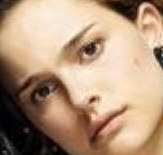

In [33]:
# image_path = file_path
res = predictor.predict_byfile(image_path,margin=40)
print(res)
res['image'].crop(res['predict'][0]['box'])

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("test/eval/eval_utkface.csv")

In [23]:
f_df = df[df['p_gender'].map(lambda x: "|" not in str(x))]

In [24]:
f_df.dropna(inplace=True)

In [25]:
from sklearn.metrics import classification_report

In [26]:
f_df = f_df[f_df['gender'].map(lambda x:x in [0,1])]

In [27]:
predicted = f_df['p_gender'].map(lambda x: int(x))

In [28]:
truth = f_df['gender'].map(lambda x: int(x))

(157, 4)
D:/WORK/freelance/agnet/dataset/utkface/part1/18_1_3_20170104221856991.jpg
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x481 at 0x1B0EF8C2C70>, 'total_face_present': 1, 'predict': [{'box': array([121.6727294921875, 82.41412353515625, 239.21249389648438,
       228.7627410888672], dtype=object), 'face_logits': 0.9999889135360718, 'gender': 'female', 'gender_score': 0.6320534944534302}], 'file_path': 'D:/WORK/freelance/agnet/dataset/utkface/part1/18_1_3_20170104221856991.jpg'}


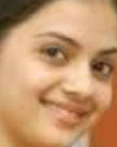

In [56]:
t = f_df[(predicted == truth)&(f_df['age']==18)]
print(t.shape)
image_path = t.sample(1).iloc[0]['file_paths']
print(image_path)

res = predictor.predict_byfile(image_path,margin=0)
print(res)
res['image'].crop(res['predict'][0]['box'])

<Axes: >

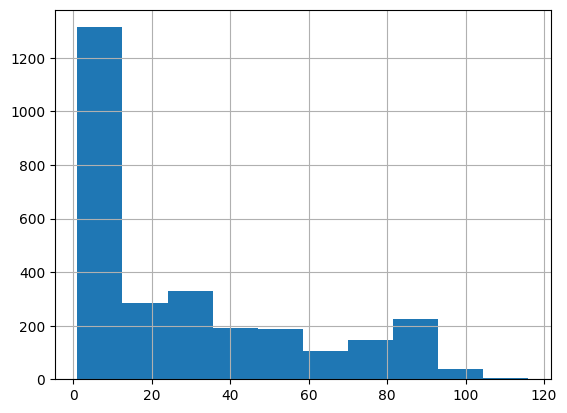

In [30]:
import matplotlib.pyplot as plt

f_df[predicted != truth]['age'].hist(bins=10)

In [31]:
print(classification_report(truth, predicted))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      6707
           1       0.84      0.70      0.76      6505

    accuracy                           0.79     13212
   macro avg       0.79      0.79      0.78     13212
weighted avg       0.79      0.79      0.78     13212



In [1]:
import json
import pandas as pd
from glob import glob

In [2]:
files = glob("dataset\eval/*.txt")

In [8]:
df_li = []
for f in files:
    a = pd.read_csv(f, sep="\t")
    df_li.append(a)

In [9]:
df = pd.concat(df_li)

In [11]:
df.reset_index(drop=True, inplace=True)

In [12]:
df.shape

(19370, 12)

In [18]:
df = df.dropna()

In [23]:
df['age'].value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

In [31]:
df['gender'].value_counts()

f    9332
m    8120
u    1099
Name: gender, dtype: int64

In [27]:
df = df[~df['age'].map(lambda x : x =='None')]

In [30]:
df[df['user_id'].map(lambda x: x == None)]

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score


### Prepare eval set

In [ ]:
import os

In [7]:
img_dir = "D:\WORK/freelance/agnet/dataset/eval/faces"
img_dir

'D:\\WORK/freelance/agnet/dataset/eval/faces'

In [69]:
cvt_path = lambda a: f"{img_dir}/{a['user_id']}/coarse_tilt_aligned_face.{a['face_id']}.{a['original_image']}"

In [72]:
df['img_path'] = df.apply(cvt_path, axis=1)

C:\Users\deepa\AppData\Local\Temp\ipykernel_19196\1187906109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['img_path'] = df.apply(cvt_path, axis=1)


In [74]:
f_df = df[['img_path','age','gender']]

In [76]:
f_df['age'].value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

In [81]:
from ast import literal_eval

t = literal_eval(f_df.iloc[0]['age'])

In [85]:
f_df['age'] = f_df['age'].map(literal_eval)

C:\Users\deepa\AppData\Local\Temp\ipykernel_19196\2411950628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df['age'] = f_df['age'].map(literal_eval)


In [87]:
f_df['gender'].value_counts()

f    9332
m    8120
u    1099
Name: gender, dtype: int64

In [88]:
f_df = f_df[f_df['gender'].map(lambda x: x in ['f','m'])]

In [89]:
f_df['gender'].value_counts()

f    9332
m    8120
Name: gender, dtype: int64

In [99]:
f_df['age'] = f_df['age'].map(lambda x: list(x) if isinstance(x,tuple) else [x])

C:\Users\deepa\AppData\Local\Temp\ipykernel_19196\2764555438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_df['age'] = f_df['age'].map(lambda x: list(x) if isinstance(x,tuple) else [x])


In [102]:
f_df.to_parquet("./dataset/eval/audience.pq",index=False)

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("./dataset/eval/eval_audience_result.csv")

In [4]:
df.head()

,img_path,age,gender,p_gender,p_age
0,D:\WORK/freelance/agnet/dataset/eval/faces/306...,[25 32],f,female,52.0
1,D:\WORK/freelance/agnet/dataset/eval/faces/306...,[25 32],m,male,61.0
2,D:\WORK/freelance/agnet/dataset/eval/faces/306...,[25 32],f,female,54.0
3,D:\WORK/freelance/agnet/dataset/eval/faces/306...,[25 32],m,male,77.0
4,D:\WORK/freelance/agnet/dataset/eval/faces/306...,[25 32],m,male,36.0


In [10]:
gender_predicted_correctly = df[df.apply(lambda x: x['gender'] == str(x['p_gender'])[0],axis=1)].shape[0]

gender_predicted_correctly / df.shape[0]

0.8333142333256933

In [56]:
fail_df = df[df.apply(lambda x: x['gender'] != str(x['p_gender'])[0],axis=1)]

img_path           D:\WORK/freelance/agnet/dataset/eval/faces/789...
age                                                          [ 8 12]
gender                                                             m
p_gender                                                      female
p_age                                                           17.0
p_age_bucketize                                                    1
l_age                                                            NaN
l_age_bucketize                                                    9
Name: 11933, dtype: object


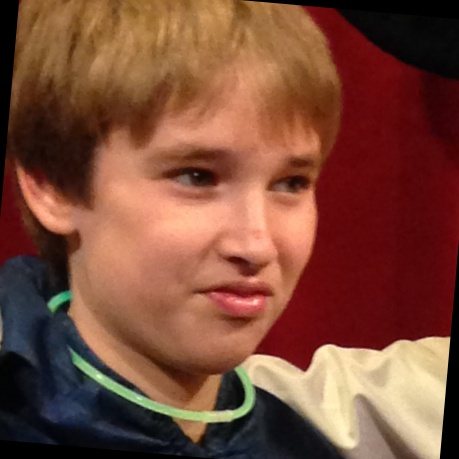

In [78]:
from PIL import Image
t = fail_df.sample(1).iloc[0]
print(t)
Image.open(t['img_path'])

In [16]:
df['p_age_bucketize'] = df['p_age'].map(lambda x: int(x//10) if x<100 else 9)

In [22]:
from ast import literal_eval

In [52]:
a = '[23 30]'

x = a.split(" ")
int(x[0][1:])

23

In [86]:
import re

def h(x):
    return list(map(lambda x: int(x//10) if x<100 else 9, map(int, re.findall(r'\d+', t))))
df['l_age'] = df['age'].map(h)

In [91]:
fail_age_df = df[~df.apply(lambda x: x['p_age_bucketize'] in x['l_age'], axis=1)]

img_path           D:\WORK/freelance/agnet/dataset/eval/faces/296...
age                                                          [ 8 12]
gender                                                             f
p_gender                                                      female
p_age                                                            5.0
p_age_bucketize                                                    0
l_age                                                         [2, 3]
l_age_bucketize                                                    9
Name: 2237, dtype: object


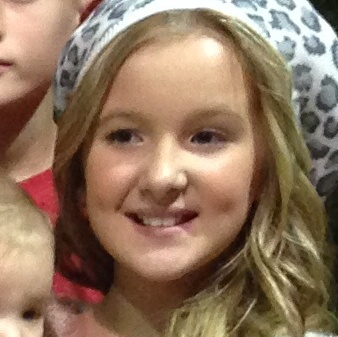

In [107]:
from PIL import Image
t = fail_age_df.sample(1).iloc[0]
print(t)
Image.open(t['img_path'])